In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

# Import relevant libraries
import numpy as np
from numpy import asarray
from PIL import Image
import os

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.losses import BinaryCrossentropy
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

# Training Images


In [2]:
directory = 'faces_train'
ls = []
label_ls = []
i = 0 
j = 0
interval = 1
path, dirs, files = next(os.walk("faces_train"))
print("len faces_train: ",len(files))
if int(len(files)/1000) > 0:
    interval = int(len(files)/1000)
for filename in os.listdir(directory):
    i += 1
    if (i % interval == 0):
        j += 1
        img = Image.open(directory + '/' + filename)
        data = asarray(img)
        ls.append(data)
        label_ls.append(1)
print("number of examples faces_train: ", j)

directory = 'no_faces_train'
i = 0 
j = 0
interval = 1
path, dirs, files = next(os.walk("no_faces_train"))
print("\nlen no_faces_train: ",len(files))
if int(len(files)/1000) > 0:
    interval = int(len(files)/1000)
for filename in os.listdir(directory):
    i += 1
    if (i % interval == 0):
        j += 1
        img = Image.open(directory + '/' + filename)
        data = asarray(img)
        ls.append(data)
        label_ls.append(0)
print("number of examples no_faces_train: ", j)

imgs_train = np.array(ls, dtype='uint8')
label_train = np.array([label_ls])

len faces_train:  10744
number of examples faces_train:  1074

len no_faces_train:  4967
number of examples no_faces_train:  1241


# Testing images

In [3]:
directory = 'faces_test'
ls = []
label_ls = []
i = 0 
j = 0
interval = 1
path, dirs, files = next(os.walk("faces_test"))
print("len faces_test: ",len(files))
if int(len(files)/1000) > 0:
    interval = int(len(files)/1000)
for filename in os.listdir(directory):
    i += 1
    if (i % interval == 0):
        j += 1
        img = Image.open(directory + '/' + filename)
        data = asarray(img)
        ls.append(data)
        label_ls.append(1)
print("number of examples faces_test: ", j)

directory = 'no_faces_test'
i = 0 
j = 0
interval = 1
path, dirs, files = next(os.walk("no_faces_test"))
print("\nlen no_faces_test: ",len(files))
if int(len(files)/1000) > 0:
    interval = int(len(files)/1000)
for filename in os.listdir(directory):
    i += 1
    if (i % interval == 0):
        j += 1
        img = Image.open(directory + '/' + filename)
        data = asarray(img)
        ls.append(data)
        label_ls.append(0)
print("number of examples no_faces_test: ", j)

imgs_test = np.array(ls, dtype='uint8')
label_test = np.array([label_ls])

len faces_test:  2136
number of examples faces_test:  1068

len no_faces_test:  945
number of examples no_faces_test:  945


In [4]:
# Normalize image vectors
imgs_train_norm = imgs_train / 255.
imgs_test_norm = imgs_test / 255.

# Reshape
label_train_T = label_train.T
label_test_T = label_test.T

print ("Number of training examples = " + str(imgs_train_norm.shape[0]))
print ("Number of testing examples = " + str(imgs_test_norm.shape[0]))
print ("Images train shape: " + str(imgs_train_norm.shape))
print ("Labels train shape: " + str(label_train_T.shape))
print ("Images test shape: " + str(imgs_test_norm.shape))
print ("Labels test shape: " + str(label_test_T.shape))

Number of training examples = 2315
Number of testing examples = 2013
Images train shape: (2315, 256, 256, 3)
Labels train shape: (2315, 1)
Images test shape: (2013, 256, 256, 3)
Labels test shape: (2013, 1)


In [5]:
# HappyModel

def HappyModel(input_shape):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    # Use the suggested model in the text above to get started, and run through the whole
    # exercise once. Then come back and add more BLOCKS. 
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)
    
    # BLOCK 1: CONV -> BN -> RELU -> MAXP
    num_filters = 32
    kernel_size = (7, 7)
    stride = (1, 1)
    X = Conv2D(num_filters, kernel_size, strides = stride, name = 'conv0')(X)

    # BLOCK 2: CONV -> BN -> RELU -> MAXP
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
        
    # BLOCK 3: CONV -> BN -> RELU -> MAXP
    X = Activation('relu')(X)
    
    # BLOCK 4: CONV -> BN -> RELU -> MAXP
    max_pool_size = (2, 2)
    X = MaxPooling2D(max_pool_size, name='max_pool')(X)
       
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model

In [6]:
happyModel = HappyModel(imgs_train_norm.shape[1:])

In [7]:
happyModel.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=["accuracy"])

In [8]:
happyModel.fit(imgs_train_norm, label_train_T, batch_size = 32, epochs = 10)

Epoch 1/5
73/73 [==============================] - 156s 2s/step - loss: 14.2603 - accuracy: 0.6786
Epoch 2/5
73/73 [==============================] - 145s 2s/step - loss: 4.7927 - accuracy: 0.7767
Epoch 3/5
73/73 [==============================] - 182s 2s/step - loss: 4.2674 - accuracy: 0.8052
Epoch 4/5
73/73 [==============================] - 161s 2s/step - loss: 3.1460 - accuracy: 0.8341
Epoch 5/5
73/73 [==============================] - 159s 2s/step - loss: 3.2887 - accuracy: 0.8501


In [9]:
preds = happyModel.evaluate(x = imgs_test_norm, y = label_test_T)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

while preds[1] < 0.8:
    happyModel.fit(imgs_train_norm, label_train_T, batch_size = 32, epochs = 1)
    preds = happyModel.evaluate(x = imgs_test_norm, y = label_test_T)
    print ("Loss = " + str(preds[0]))
    print ("Test Accuracy = " + str(preds[1]))

63/63 [==============================] - 35s 557ms/step - loss: 6.6006 - accuracy: 0.7288
Loss = 6.60059118270874
Test Accuracy = 0.7287630438804626
63/63 [==============================] - 42s 664ms/step - loss: 7.7235 - accuracy: 0.6791
Loss = 7.723496913909912
Test Accuracy = 0.6790859699249268
63/63 [==============================] - 37s 592ms/step - loss: 4.3884 - accuracy: 0.7834
Loss = 4.388425350189209
Test Accuracy = 0.7834078669548035
63/63 [==============================] - 36s 569ms/step - loss: 17.4308 - accuracy: 0.5862
Loss = 17.430755615234375
Test Accuracy = 0.5861897468566895
63/63 [==============================] - 35s 550ms/step - loss: 13.9568 - accuracy: 0.7104
Loss = 13.956836700439453
Test Accuracy = 0.7103825211524963
63/63 [==============================] - 34s 539ms/step - loss: 18.2262 - accuracy: 0.7059
Loss = 18.22623634338379
Test Accuracy = 0.7059115767478943


KeyboardInterrupt: 

In [ ]:
# plots the model in a nice layout and save it as ".png"
plot_model(happyModel, to_file='HappyModel.png')

face


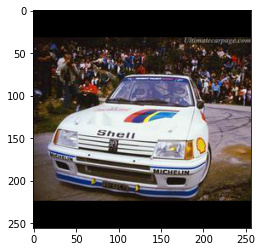

In [21]:
img_path = 'faces_test/1_10.jpg'
img = image.load_img(img_path, target_size=(256, 256))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

if happyModel.predict(x)[0][0] == 0:
    print("no face")
elif happyModel.predict(x)[0][0] == 1:
    print("face")

face


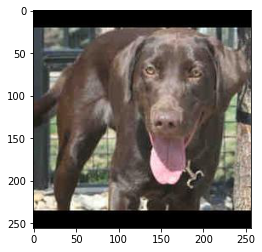

In [19]:
img_path = 'no_faces_test/0_3166.jpg'
img = image.load_img(img_path, target_size=(256, 256))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

if happyModel.predict(x)[0][0] == 0:
    print("no face")
elif happyModel.predict(x)[0][0] == 1:
    print("face")